In [1]:
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from dateutil.parser import parse
from IPython.display import display, HTML
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk import ngrams
from collections import Counter
import numpy as np
import string as string_
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
import tempfile
import warnings
import eli5
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
display(HTML("<style>.container { width:95% !important; }</style>"))

Using TensorFlow backend.


In [2]:
CORES = cpu_count()

# Data Extraction

In [3]:
df = pd.read_csv(filepath_or_buffer = "training.1600000.processed.noemoticon.csv", 
                 encoding = "ISO-8859-1", 
                 names = ["sentiment", "ids", "date", "flag", "user", "text"])

In [4]:
df.shape

(1600000, 6)

In [5]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [6]:
df.tail()

,sentiment,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


# Initial Data Cleaning

#### Change labels to binary format

In [7]:
df.sentiment.replace({4:1}, inplace=True)

In [8]:
# 1 = positive
# 0 = negative

df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

#### Extract Dates for analysis

In [9]:
# date functions
month_map = {
    "Jan":"01",
    "Feb":"02",
    "Mar":"03",
    "Apr":"04",
    "May":"05",
    "Jun":"06",
    "Jul":"07",
    "Aug":"08",
    "Sep":"09",
    "Oct":"10",
    "Nov":"11",
    "Dec":"12",
}

def extract_year(string):
    return re.search('(\d{4})', string).group()

def extract_time(string):
    return re.search('(?:[01]\d|2[0123]):(?:[012345]\d):(?:[012345]\d)', string).group()

def extract_day(string):
    return string.split()[0]

def extract_date(string, month_map = month_map):    
    year = extract_year(string)
    date = string.split()[:3]
    return year + '-' + month_map[date[1]] + '-' + date[2]

def extract_datetime(string, month_map = month_map):
    date = extract_date(string)
    time = extract_time(string)
    return date + " " + time

In [10]:
df.rename(index=str, columns={"date":"date_old"}, inplace=True)

df['datetime'] = df.date_old.apply(lambda x: extract_datetime(x))
df['time'] = df.date_old.apply(lambda x: extract_time(x))
df['date'] = df.date_old.apply(lambda x: extract_date(x))
df['day']  = df.date_old.apply(lambda x: extract_day(x))

df.drop(['date_old', 'flag', 'ids'], axis=1, inplace=True)

In [11]:
df.head()

,sentiment,user,text,datetime,time,date,day
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06 22:19:45,22:19:45,2009-04-06,Mon
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06 22:19:49,22:19:49,2009-04-06,Mon
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06 22:19:53,22:19:53,2009-04-06,Mon
3,0,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,22:19:57,2009-04-06,Mon
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06 22:19:57,22:19:57,2009-04-06,Mon


# Data Exploration

#### At first glance, with uncleaned raw text, we have a vocabulary of over 1.19 million unique words, although this includes strings that will later be removed, including usernames, urls, words attached to punctuation and so on.  

In [12]:
len(set(df['text'].str.cat(sep=' ').lower().split()))

1193584

#### The average length of each tweet is around 13 words

In [13]:
sum([len(sentence.split()) for sentence in df.text]) / df.shape[0]

13.176150625

#### Tweets are between  April 6, 2009 to June 25, 2009.

In [14]:
df.datetime.min(), df.datetime.max()

('2009-04-06 22:19:45', '2009-06-25 10:28:31')

#### We can split the data into each sentiment group, to see if there are any noticable distinguishments that could help us in the later stages of feature selection, engineering and cleaning.

In [15]:
df_pos = df[df.sentiment==1]
df_neg = df[df.sentiment==0]

#### Looking and the number of tweets for both sentiment classes for each day of the week, we can see that positive tweets seem to occur less on wednesdays and thursdays, and more on a mondays and sundays. Negative tweets seem more evenly distributed, with slight increases across the weekends. However, this could be caused by the methods of data collection.

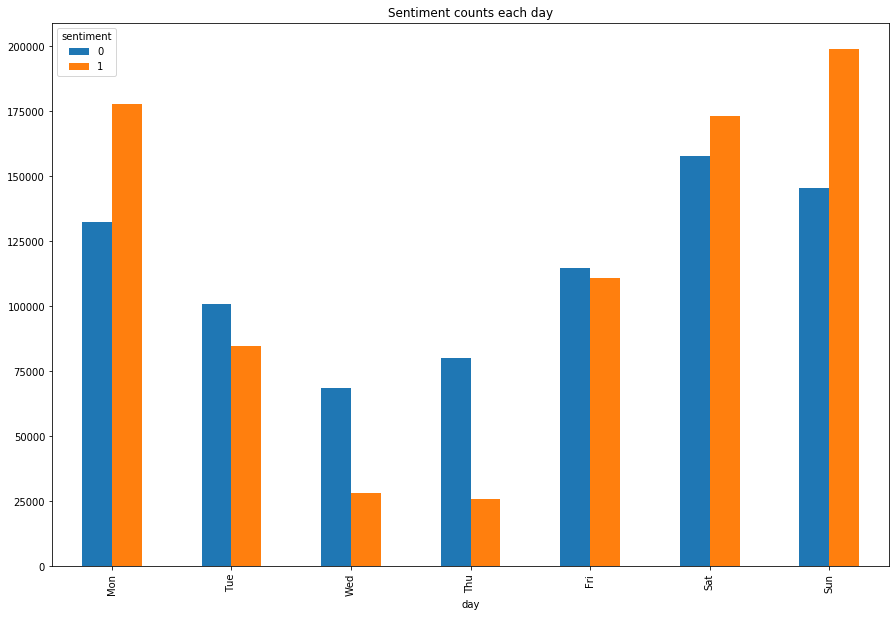

In [16]:
index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pd.crosstab(df['day'],df['sentiment']).reindex(index).plot.bar(title='Sentiment counts each day', figsize=(15, 10))

#### Looking at the time each sentiment class occurs does not provide much valuable information.

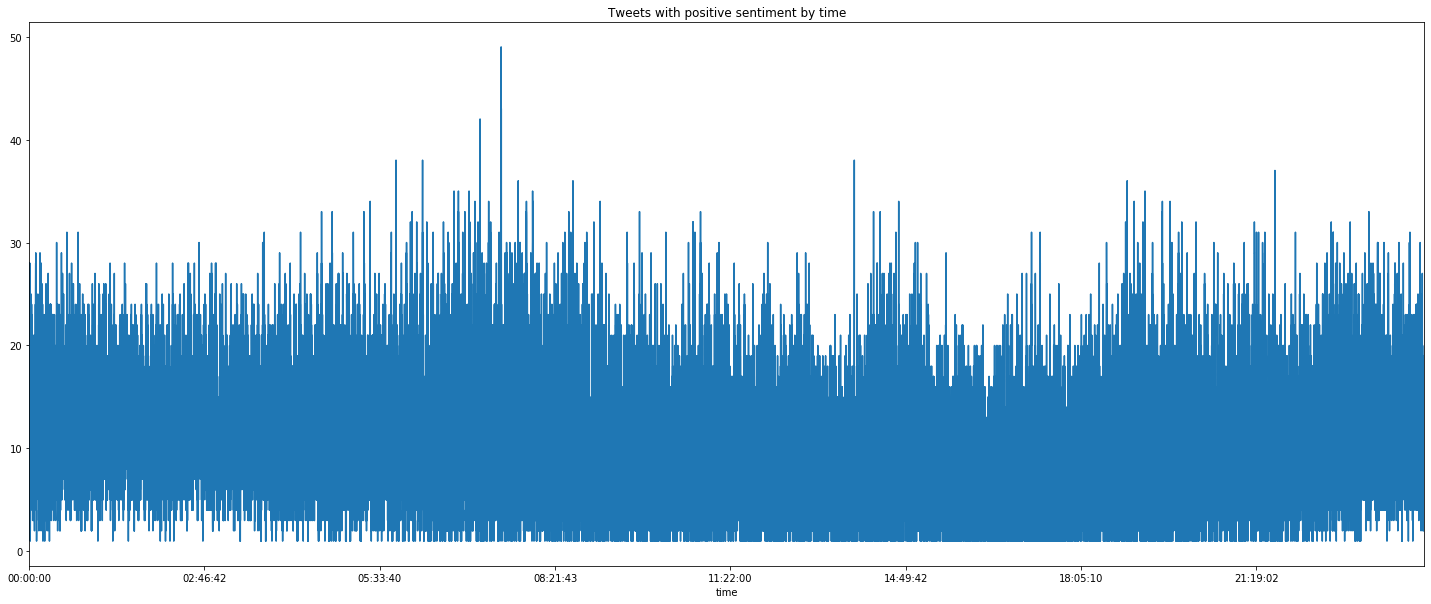

In [17]:
df_pos.groupby('time').sentiment.count().plot(figsize=(25, 10), title='Tweets with positive sentiment by time')

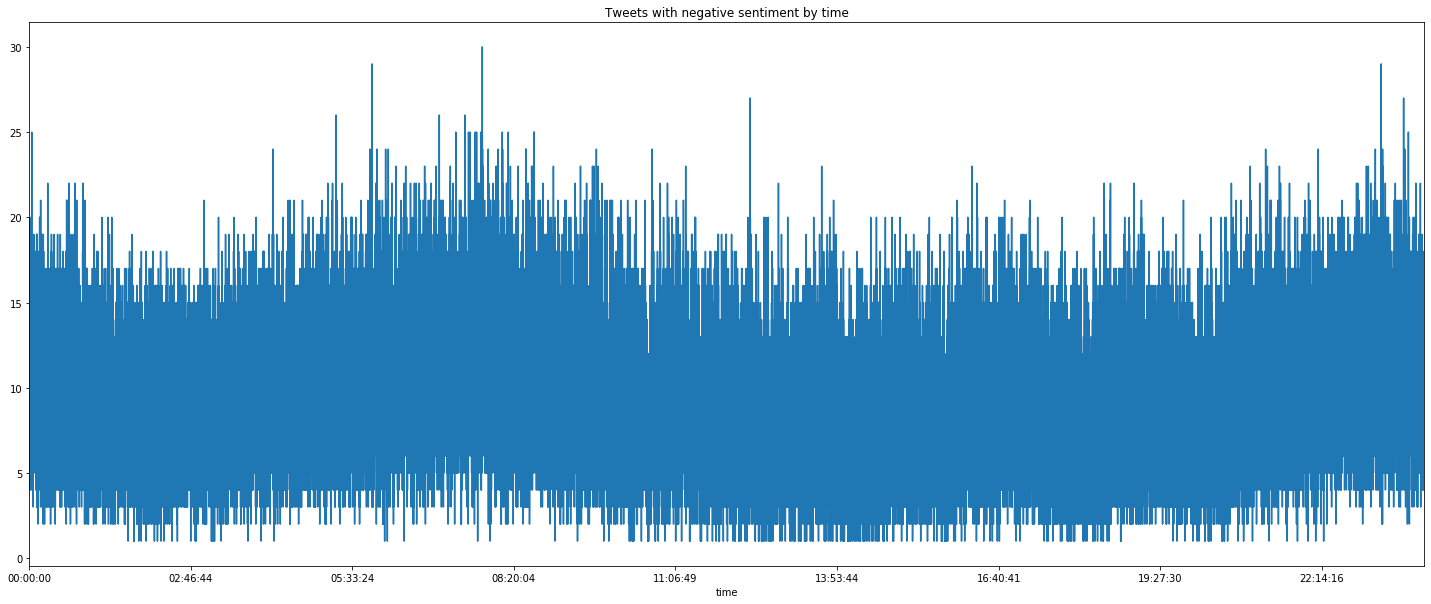

In [18]:
df_neg.groupby('time').sentiment.count().plot(figsize=(25, 10), title='Tweets with negative sentiment by time')

In [19]:
def get_wordcloud(text, custom_stopwords = None):
    if custom_stopwords: 
        custom_stopwords = list(STOPWORDS) + custom_stopwords
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = custom_stopwords if custom_stopwords else STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (30, 20),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

####  Wordclouds for both classes (pre-cleaning) give some valuable insight. Words such as 'congrats', 'thanks', 'best' and 'love' appear in the positive sentiment tweets...

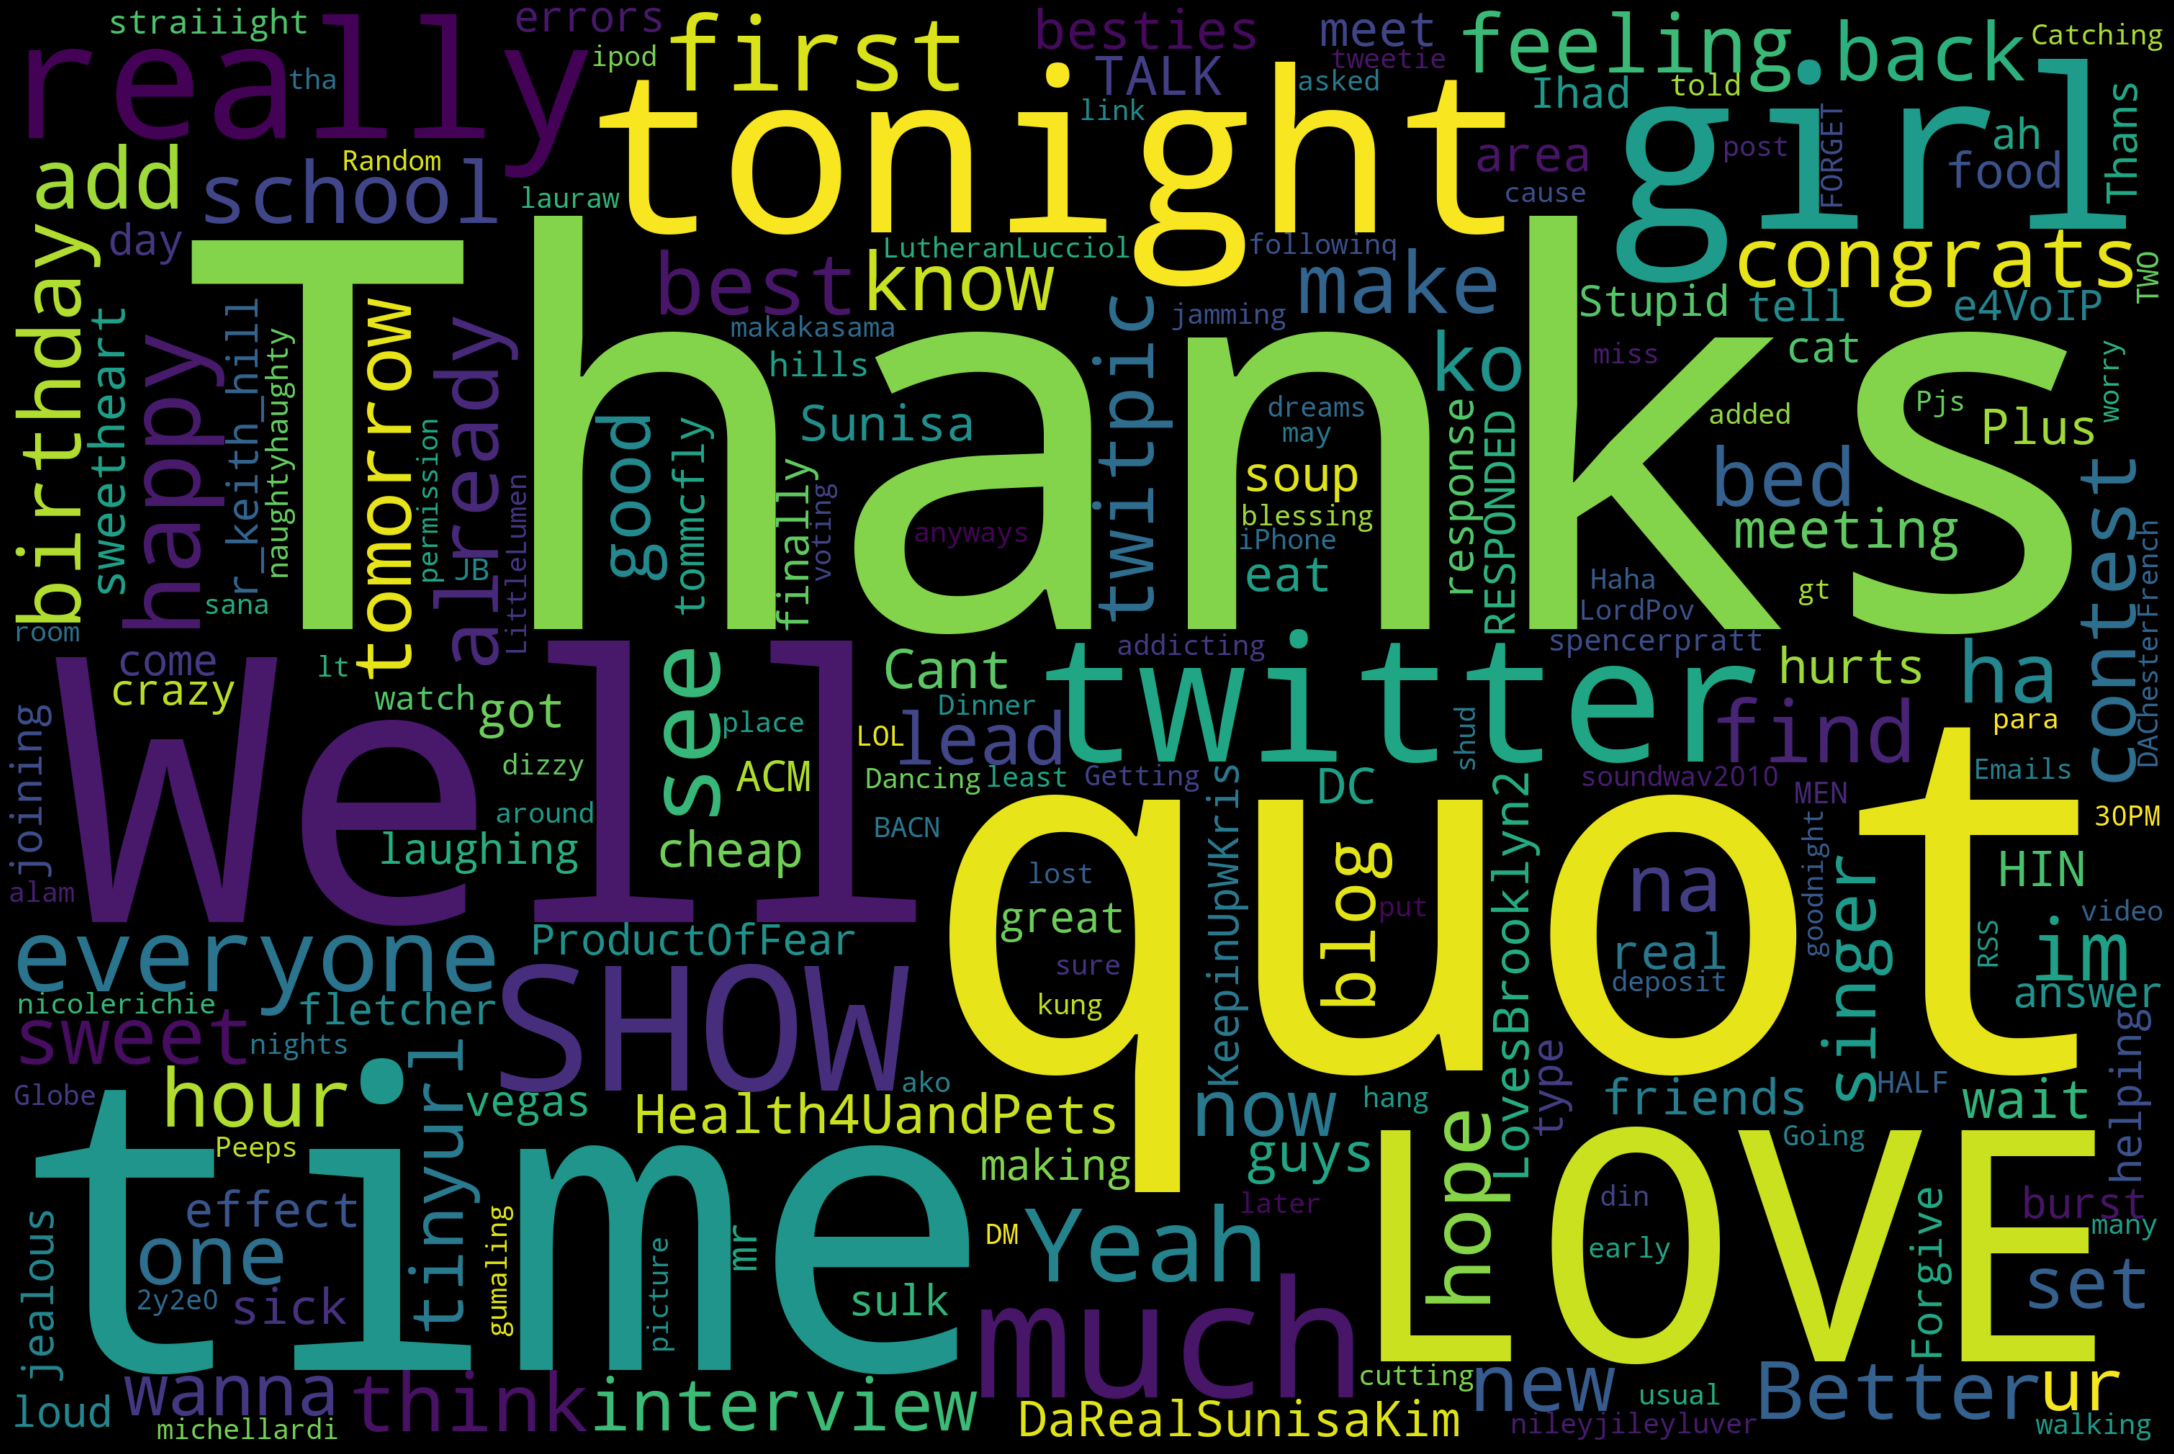

In [20]:
get_wordcloud(df_pos.text)

#### ...and words from the negative sentiment tweets' wordcloud include 'RIP', 'Sad' and 'ugh'

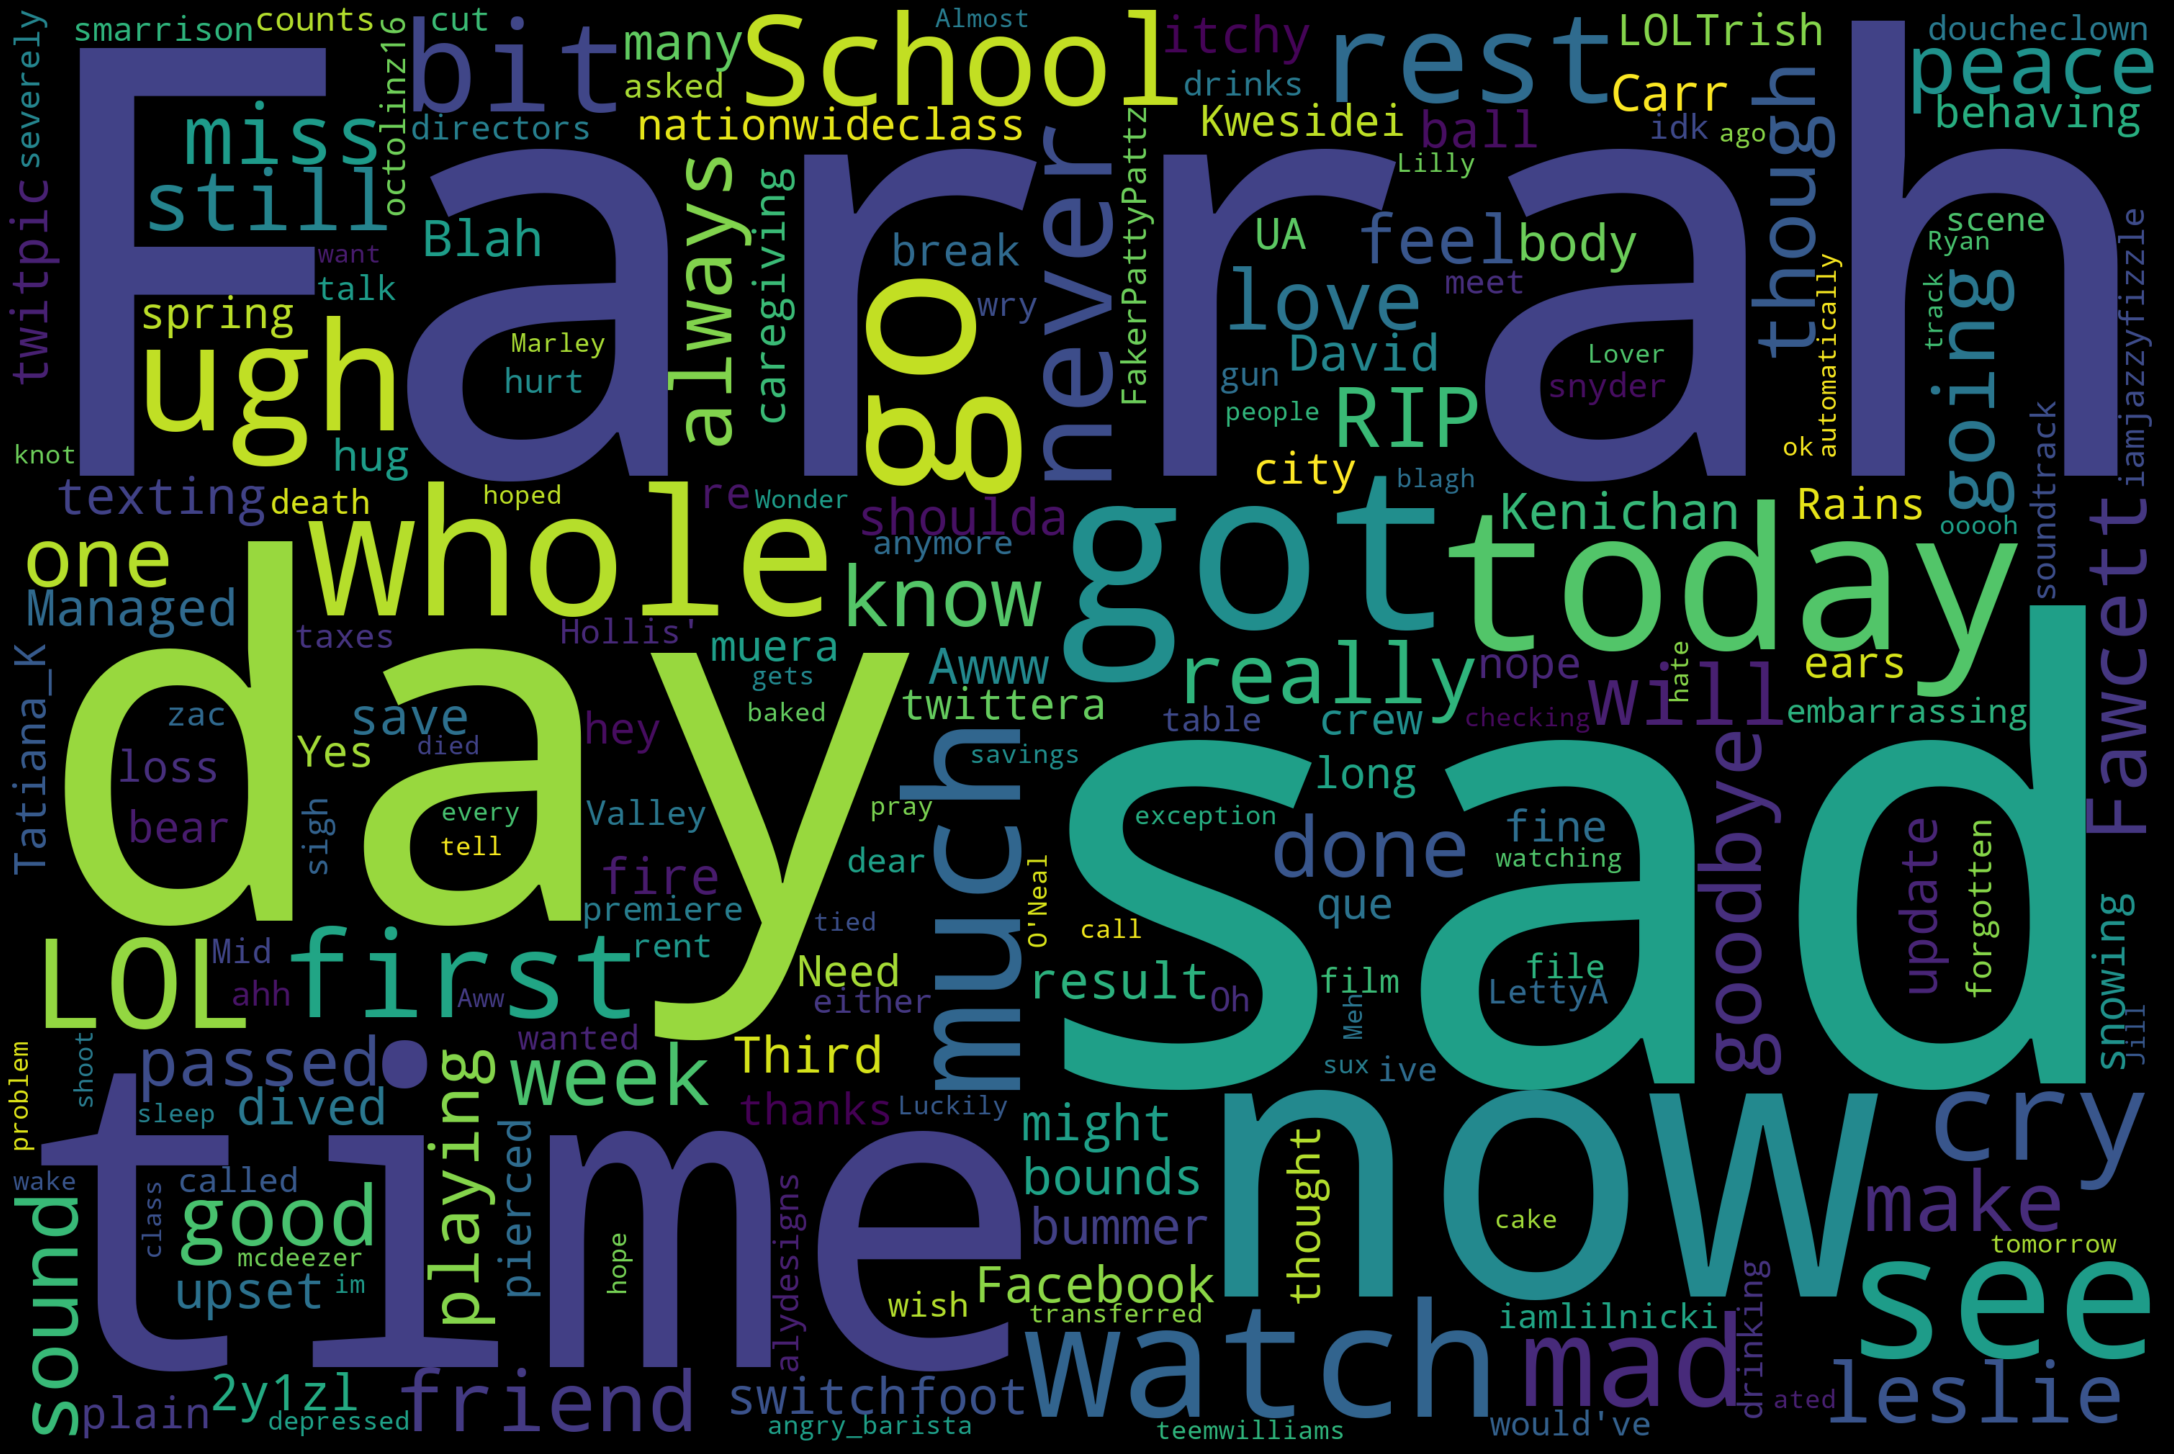

In [21]:
get_wordcloud(df_neg.text)

# Text processing

In [ ]:

def clean_text(df):

    df['clean_text'] = df.text.apply(lambda x: x.lower()) # lower case
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(r"http\S+", "", x)) # remove url
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub('@[^\s]+','', x)) # remove usernames
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(r'#([^\s]+)', r'\1', x)) # remove # from hashtag
    df['clean_text'] = df.clean_text.apply(lambda x: x.translate(str.maketrans('', '', string_.punctuation))) # remove punctuation
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(' +', ' ', x.strip())) # remove trailing and double whitespace
    df['clean_text'] = df.clean_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stopwords.words('english'))) # remove stopwords
    
    return df

##### Apply text cleaning function to dataframe and remove rows with less than 1 word remaining 

In [ ]:
def apply_clean_text_to_row(df):
    return clean_text(df)

def parallelize_function(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    with Pool(n_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

In [3]:
if not os.path.isfile("df_clean.csv"):
    df = parallelize_function(df, apply_clean_text_to_row, CORES)
    df.to_csv("df_clean.csv", index=False)
else:
    df = pd.read_csv("df_clean.csv")

In [4]:
df = df[df.clean_text.str.split().str.len() > 1]
df.reset_index(inplace=True, drop=True)
df.head()

,sentiment,user,text,datetime,time,date,day,clean_text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06 22:19:45,22:19:45,2009-04-06,Mon,awww thats bummer shoulda got david carr third day
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06 22:19:49,22:19:49,2009-04-06,Mon,upset cant update facebook texting might cry result school today also blah
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06 22:19:53,22:19:53,2009-04-06,Mon,dived many times ball managed save 50 rest go bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,whole body feels itchy like fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,behaving im mad cant see


In [5]:
df.shape

(1545489, 8)

In [6]:
df.sentiment.value_counts()

0    776188
1    769301
Name: sentiment, dtype: int64

## Modelling with TFIDF Vectorizer 

#### Split the data into its training and testing subsets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.sentiment, test_size = 0.2, random_state = 0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1236391,)
y_train shape: (1236391,)
X_test shape: (309098,)
y_test shape: (309098,)


#### Create a simple baseline model using a naive bayes classifier

In [9]:
tfidf_args = {
    'ngram_range': (1, 2),
    'use_idf': True,
    'sublinear_tf': False,
}

pipe_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', MultinomialNB())
])

nb_path = "nb_pipe.sav"
if not os.path.isfile(nb_path):
    best_nb_pipe = pipe_nb.fit(X_train, y_train)
    dump(pipe_nb, nb_path) 
else:
    best_nb_pipe = load(nb_path) 
print(classification_report(y_test, best_nb_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79    155303
           1       0.80      0.75      0.78    153795

    accuracy                           0.78    309098
   macro avg       0.79      0.78      0.78    309098
weighted avg       0.79      0.78      0.78    309098



#### Create a simple pipeline for to vectorize the text and classify using logistic regression

In [40]:
pipe_logit = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', LogisticRegression())
], memory=tempfile.gettempdir())


param_grid_logit = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[.1, 1, 10]
}
    
gs_logit = GridSearchCV(pipe_logit, param_grid_logit, n_jobs=9, cv=3, verbose=10, scoring='accuracy')

In [41]:
logit_path = "logit_pipe.sav"
if not os.path.isfile(logit_path):
    best_logit_pipe = gs_logit.fit(X_train, y_train)
    dump(best_logit_pipe.best_estimator_, logit_path) 
else:
    best_logit_pipe = load(logit_path)

In [42]:
print(classification_report(y_test, best_logit_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    155303
           1       0.80      0.80      0.80    153795

    accuracy                           0.80    309098
   macro avg       0.80      0.80      0.80    309098
weighted avg       0.80      0.80      0.80    309098



#### Create a simple pipeline for to vectorize the text and classify using a linear support vector classifier

In [43]:
pipe_svc = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', LinearSVC())
], memory=tempfile.gettempdir())


param_grid_svc = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[.1, 1, 10],
    'classifier__dual':[True, False]
}
    
gs_svc = GridSearchCV(pipe_svc, param_grid_svc, n_jobs=12, cv=3, verbose=3, scoring='accuracy', error_score=0.0)

In [44]:
svc_path = "svc_pipe.sav"
if not os.path.isfile(svc_path):
    best_svc_pipe = gs_svc.fit(X_train, y_train)
    dump(best_svc_pipe.best_estimator_, svc_path) 
else:
    best_svc_pipe = load(svc_path)

In [45]:
print(classification_report(y_test, best_svc_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    155303
           1       0.80      0.80      0.80    153795

    accuracy                           0.80    309098
   macro avg       0.80      0.80      0.80    309098
weighted avg       0.80      0.80      0.80    309098



#### Roc curves

In [46]:
nb_probas = best_nb_pipe.predict_proba(X_test)[:, 1]
logit_probas = best_logit_pipe.predict_proba(X_test)[:, 1]
svc_decision_func = best_svc_pipe.decision_function(X_test)

In [47]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_probas)
fpr_logit, tpr_logit, thresholds_logit= roc_curve(y_test, logit_probas)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc_decision_func)

In [48]:
nb_auc = np.round(roc_auc_score(y_test, nb_probas), 2)
logit_auc = np.round(roc_auc_score(y_test, logit_probas), 2)
svc_auc = np.round(roc_auc_score(y_test, svc_decision_func), 2)

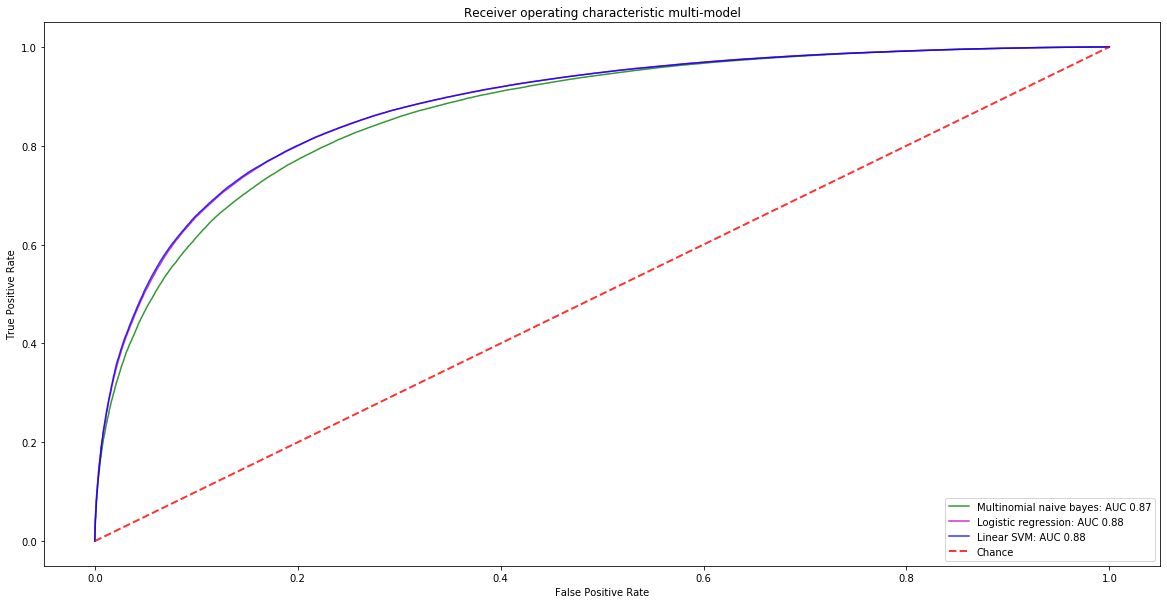

In [49]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(fpr_nb, tpr_nb, color='g', label=f'Multinomial naive bayes: AUC {nb_auc}', alpha=.8)
plt.plot(fpr_logit, tpr_logit, color='m', label=f'Logistic regression: AUC {logit_auc}', alpha=.8)
plt.plot(fpr_svc, tpr_svc, color = 'b', label=f'Linear SVM: AUC {svc_auc}', alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic multi-model')
plt.legend(loc="lower right")
plt.show()

#### Looking at the coefficients for the best performing models, we can determine the most influential words for each class

In [50]:
vectorizer_logit = best_logit_pipe.named_steps['vectorizer']
display(eli5.show_weights(best_logit_pipe.named_steps['classifier'], top=(10, 10), vec=vectorizer_logit))

Weight?,Feature
+15.489,cant wait
+9.240,thanks
+9.127,wish luck
+8.844,thank
+7.776,cannot wait
+7.513,smile
+7.309,love
+7.163,welcome
+7.107,awesome
+6.906,proud


#### Explaining the models predictions can provide a deeper level of understanding as to how influential coefficients are

In [51]:
# get vocabulary from tdidf
vocab = {v: k for k, v in best_logit_pipe.named_steps['vectorizer'].vocabulary_.items()}

test_segment = X_test.iloc[0]
eli5.explain_prediction(best_logit_pipe.named_steps['classifier'], 
                        best_logit_pipe.named_steps['vectorizer'].transform([test_segment]),
                        top=(10, 10),
                        feature_names = vocab)

Explanation(estimator="LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='warn', n_jobs=None, penalty='l2',\n                   random_state=None, solver='warn', tol=0.0001, verbose=0,\n                   warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='poor', weight=2.487288828156778, std=None, value=0.19732625454220445), FeatureWeight(feature='dont like', weight=1.103725695397066, std=None, value=0.22314292548006753), FeatureWeight(feature='dont', weight=0.6808239242020577, std=None, value=0.13071342733838215), FeatureWeight(feature='everyone else', weight=0.5351061392755903, std=None, value=0.2716465551279652), FeatureWeight(feature='muller rice', weight=0.1536984598770415, std=None, value=0.42690171970152707), FeatureWeight(feature='throw', weight=0.0825384740340182, std=None, value=0.2590491902513977), FeatureWeight(feature='muller', weight=0.07639558340403159, std=None, value=0.398226825808634), FeatureWeight(feature='else', weight=0.032428731842632584, std=None, value=0.2097182478844453)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.4684577387903359, std=None, value=1.0), FeatureWeight(feature='else dont', weight=-0.3764594108920105, std=None, value=0.3798323144800609), FeatureWeight(feature='jade', weight=-0.23936281127003614, std=None, value=0.3209887945592165), FeatureWeight(feature='like', weight=-0.22257709142072385, std=None, value=0.1261442717733482), FeatureWeight(feature='everyone', weight=-0.10695546024015659, std=None, value=0.17583401022980275), FeatureWeight(feature='rice', weight=-0.0257883469626487, std=None, value=0.27264895694492525)], pos_remaining=0, neg_remaining=0), proba=0.9761633348659591, score=-3.712404976613304, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

# Word Embeddings

In [ ]:
sentences = [text.split() for text in df.clean_text]

#### Transform clean text, find bigrams

In [ ]:
phrases = Phrases(sentences, min_count=1000, threshold=50)
bigrams = Phraser(phrases)

In [ ]:
def bigram_example(sentences): 
    for i in range(len(sentences)):
        bg = bigrams[sentences[i]]
        for word in bg:
            if '_' in word:
                return bg

bigram_example(sentences)

In [ ]:
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=300,
                     negative=10,
                     workers= CORES - 2)

In [ ]:
w2v_model.build_vocab(bigrams[sentences], progress_per=1e5)

In [ ]:
w2v_model.train(bigrams[sentences], total_examples=w2v_model.corpus_count, epochs=32, report_delay=1)

In [ ]:
w2v_model.save('word2vec_model')

In [ ]:
w2v_model.wv.init_sims(replace=True)

In [ ]:
# Number of words in this vocabulary after word2vec training
w2v_model.wv.syn0.shape

In [29]:
w2v_model = Word2Vec.load('word2vec_model')

#### By training the word2vec model on our corpus we get some interesting similarities between the vector representations of different words

In [33]:
w2v_model.most_similar('love')

[('lt3', 0.5783222913742065),
 ('luv', 0.5626571774482727),
 ('adore', 0.5496283173561096),
 ('loves', 0.5491652488708496),
 ('loved', 0.5306352376937866),
 ('amazing', 0.5005226135253906),
 ('miss', 0.49466440081596375),
 ('â\x99¥', 0.4934868812561035),
 ('looove', 0.49197763204574585),
 ('lovee', 0.48131513595581055)]

In [34]:
w2v_model.most_similar('sad')

[('depressed', 0.5929237604141235),
 ('upset', 0.5877488851547241),
 ('bummed', 0.5377104878425598),
 ('sadd', 0.5375199317932129),
 ('disappointed', 0.47573450207710266),
 ('saad', 0.46969205141067505),
 ('heartbroken', 0.4613623023033142),
 ('sadi', 0.4574466347694397),
 ('happy', 0.43624091148376465),
 ('upsetting', 0.43110981583595276)]

In [35]:
w2v_model.similarity('love', 'hate')

0.3548553440537021

In [36]:
w2v_model.most_similar('twitter')

[('facebook', 0.6288264989852905),
 ('twiiter', 0.5466874837875366),
 ('twiter', 0.5423733592033386),
 ('tweeter', 0.5371675491333008),
 ('tweets', 0.5332809090614319),
 ('twitted', 0.5304079651832581),
 ('tweet', 0.5288722515106201),
 ('tweetdeck', 0.5279922485351562),
 ('twitters', 0.5218958258628845),
 ('lj', 0.5216009616851807)]

In [37]:
df.head()

,sentiment,user,text,datetime,time,date,day,clean_text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06 22:19:45,22:19:45,2009-04-06,Mon,awww thats bummer shoulda got david carr third day
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06 22:19:49,22:19:49,2009-04-06,Mon,upset cant update facebook texting might cry result school today also blah
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06 22:19:53,22:19:53,2009-04-06,Mon,dived many times ball managed save 50 rest go bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,whole body feels itchy like fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,behaving im mad cant see


#### We can take the mean of the unigram and bigram vector representations in a given sentence to produce an array that represents the sentence. This method does not take into account the order of words in a sequence, but this may not be necessary for the task at hand.

In [ ]:
def mean_sentence(w2v, sentence):
    return np.array(np.mean([w2v[word] if word in w2v else np.zeros(w2v.wv.vector_size) for word in sentence], axis=0))

In [ ]:
def apply_mean_sentence(df):
    arr = df.clean_text.apply(lambda x: mean_sentence(w2v_model, x))
    return pd.DataFrame(index = arr.index, 
                        data = np.array([arr.tolist() for arr in arr.values]), 
                        columns = range(w2v_model.wv.vector_size))

w2v_df = parallelize_function(df, apply_mean_sentence, CORES)

#### For convenience, we can save the sentence vector transformations in a dataframe, with the columns representing the mean value of all the words in a given sentence accross that dimension for all dimensions in the embeddings

In [ ]:
assert w2v_df.shape[0] == df.shape[0]
assert w2v_df.shape[1] == w2v_model.wv.vector_size

In [ ]:
w2v_df.head()

In [ ]:
w2v_df.shape

In [ ]:
w2v_df.to_csv("w2v_df.csv", index=False)

In [52]:
w2v_df = pd.read_csv("w2v_df.csv")

In [53]:
X_train_w2v = w2v_df.iloc[X_train.index]
X_test_w2v = w2v_df.iloc[X_test.index]

In [55]:
logit_w2v = LogisticRegression().fit(X_train_w2v, y_train)

In [56]:
preds_w2v = logit_w2v.predict(X_test_w2v)

In [57]:
print(classification_report(y_test, preds_w2v))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57    155303
           1       0.55      0.49      0.52    153795

    accuracy                           0.55    309098
   macro avg       0.55      0.55      0.54    309098
weighted avg       0.55      0.55      0.54    309098



#### Doc2vec

In [ ]:
tagged_tweets = [TaggedDocument(words=tweet.split(), tags=[str(i)]) for i, tweet in enumerate(df.clean_text)]

In [ ]:
d2v_model = Doc2Vec(size=300,
                    alpha=.025, 
                    hs=0,
                    min_count=10,
                    workers=CORES - 2)

In [ ]:
d2v_model.build_vocab(tagged_tweets, progress_per=1e5)

In [ ]:
d2v_model.train(tagged_tweets, 
                total_examples=d2v_model.corpus_count,
                epochs=32, 
                report_delay=1)

In [ ]:
d2v_model.save('doc2vec_model')

In [ ]:
d2v_model = Doc2Vec.load('doc2vec_model')

In [ ]:
d2v_df = pd.DataFrame(index = [doc.tags[0] for doc in tagged_tweets], 
                      data = [d2v_model.docvecs[i] for i in range(len(d2v_model.docvecs))], 
                      columns = range(d2v_model.wv.vector_size))

In [ ]:
d2v_df.to_csv("d2v_df.csv", index=False)

In [58]:
d2v_df = pd.read_csv("d2v_df.csv")

In [59]:
d2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.978203,-0.128416,-0.594961,0.323039,0.087902,0.128751,-0.756523,0.182673,0.402945,0.312821,...,-0.078654,-0.524058,0.445052,-0.040782,-0.008390,-0.115217,0.364021,0.426618,-0.077968,-0.046663
1,-0.492855,-0.383687,-0.180741,0.243592,0.326483,-1.079847,-0.062683,0.510958,0.339631,-0.153653,...,0.547056,-0.627208,-0.145178,-0.665055,0.564915,0.175473,-0.383865,0.311817,-0.378239,-0.233752
2,0.303953,0.301151,-0.207239,0.214936,0.037094,-0.134717,0.007479,0.313321,0.043426,0.661043,...,0.522524,0.149570,-0.021789,0.299167,-0.558741,0.572444,-0.178388,-0.081517,-0.229895,-0.297540
3,0.079975,-0.148747,-0.436301,0.347109,0.311760,-0.314524,0.202062,-0.236774,0.002442,-0.095581,...,-0.104192,-0.327618,0.195108,-0.234135,0.061748,-0.000989,0.177559,-0.025311,-0.143834,-0.169411
4,-0.108825,-0.197993,0.133238,-0.054245,-0.172475,0.191923,0.166518,0.249852,0.037143,0.264036,...,0.051639,-0.290914,-0.322417,-0.266798,-0.027435,0.132499,0.004741,0.043493,-0.362408,-0.452440


In [60]:
d2v_df.shape

(1545489, 300)

In [61]:
X_train_d2v = d2v_df.iloc[X_train.index]
X_test_d2v = d2v_df.iloc[X_test.index]

In [62]:
logit_d2v = LogisticRegression().fit(X_train_d2v, y_train)

In [63]:
preds_d2v = logit_w2v.predict(X_test_d2v)

In [64]:
print(classification_report(y_test, preds_d2v))

              precision    recall  f1-score   support

           0       0.50      0.76      0.60    155303
           1       0.48      0.22      0.30    153795

    accuracy                           0.49    309098
   macro avg       0.49      0.49      0.45    309098
weighted avg       0.49      0.49      0.45    309098



# Deep Learning

#### At first, we can try a simple seqential model to test if there is any value in neural networks for the problem at hand

In [22]:
word_limit = 10000
tokenize = text.Tokenizer(num_words=word_limit)
tokenize.fit_on_texts(X_train)

x_train_seq = tokenize.texts_to_matrix(X_train)
x_test_seq = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [23]:
seq_model = Sequential()
seq_model.add(Dense(512, input_shape=(word_limit,)))
seq_model.add(Activation('relu'))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(1, activation='sigmoid'))

seq_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 5,121,025
Trainable params: 5,121,025
Non-trainable params: 0
_________________________________________________________________


In [37]:
seq_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [69]:
if not os.path.isfile('seq_model.h5'):
    print("fitting...")
    seq_model_fit = seq_model.fit(x_train_seq, y_train, batch_size=512, epochs=2, verbose=1, validation_split=0.1)
    seq_model.save('seq_model.h5')
else:
    seq_model.load_weights('seq_model.h5')

In [39]:
seq_score = seq_model.evaluate(x_test_seq, y_test, batch_size=512, verbose=1)
print('Accuracy:', seq_score[1])

309098/309098 [==============================] - 33s 108us/step
Accuracy: 0.7918556573974107


#### LSTM

#### We can try a slightly different tokenization method, padding the sequences

In [26]:
tokenize_lstm = text.Tokenizer()
tokenize_lstm.fit_on_texts(X_train)

In [27]:
x_train = pad_sequences(tokenize_lstm.texts_to_sequences(X_train), maxlen=50)
x_test = pad_sequences(tokenize_lstm.texts_to_sequences(X_test), maxlen=50)

#### Rather than create a new embedding layer, we can make use of the word embeddings we currently have, through word2vec

In [30]:
def build_w2v_matrix():
    return np.array([w2v_model.wv[word] if word in w2v_model.wv else np.zeros(300) for word, i in tokenize_lstm.word_index.items()])

vocab_size = len(tokenize_lstm.word_index)
w2v_vector_size = w2v_model.wv.vector_size

w2v_matrix = build_w2v_matrix()

# insert row for padding
w2v_matrix = np.insert(w2v_matrix, 0, np.zeros(300), 0)
vocab_size += 1
print(w2v_matrix.shape)

(385920, 300)


In [31]:
embedded_layer = Embedding(vocab_size, w2v_vector_size, weights=[w2v_matrix], input_length=50, trainable=False)

In [32]:
model_lstm = Sequential()
model_lstm.add(embedded_layer)
model_lstm.add(SpatialDropout1D(0.4))
model_lstm.add(LSTM(150, dropout=0.25, recurrent_dropout=0.25))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           115776000 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 116,046,751
Trainable params: 270,751
Non-trainable params: 115,776,000
_________________________________________________________________


In [35]:
model_lstm.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
lstm_checkpoint = ModelCheckpoint('weights{epoch:08d}.h5', 
                                   save_weights_only=True, period=5)

In [ ]:
if not os.path.isfile('model_lstm_fit.h5'):
    model_lstm_fit = model_lstm.fit(x_train, y_train,
                        batch_size=512,
                        epochs=5,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=[lstm_checkpoint])
    model_lstm.save('model_lstm_fit.h5')
else:
    model_lstm.load_weights('model_lstm_fit.h5')

In [36]:
lstm_score = model_lstm.evaluate(x_test, y_test, batch_size=512, verbose=1)
print('Accuracy:', lstm_score[1])

309098/309098 [==============================] - 152s 493us/step
Accuracy: 0.7991316669477798
